# Neural Collaborative Filtering for Rating Prediction

## Motivation

The original NCF (He et al., 2017) was designed for **implicit feedback** (binary interactions). 

For **explicit feedback** (ratings 1-5), we modify:
1. **Loss**: BCE → MSE (regression task)
2. **Output**: Scaled sigmoid to [1, 5]
3. **Data**: Actual ratings, no negative sampling

## Models to Compare

| Model | Description |
|-------|-------------|
| **GMF** | Generalized Matrix Factorization (linear) |
| **MLP** | Multi-Layer Perceptron (non-linear) |
| **NeuMF-end** | GMF + MLP trained end-to-end |
| **NeuMF-pre** | GMF + MLP with pre-trained initialization |

## Step 1: Setup and Imports

In [ ]:
import os
import sys
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Add src to path
current_dir = os.getcwd()
path = current_dir
while True:
    if os.path.basename(path) == "src":
        if path not in sys.path:
            sys.path.insert(0, path)
        break
    parent = os.path.dirname(path)
    if parent == path:
        break
    path = parent

from helpers import download_ml1m_dataset

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

## Step 2: Hyperparameters

In [ ]:
# Paths
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), '..', 'data')
MODEL_PATH = os.path.join(os.path.dirname(os.getcwd()), '..', 'models')
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

# Hyperparameters
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.2
BATCH_SIZE = 256
EPOCHS = 30
FACTOR_NUM = 32
NUM_LAYERS = 3
EARLY_STOPPING_PATIENCE = 5
TEST_RATIO = 0.2

RATING_MIN = 1.0
RATING_MAX = 5.0

## Step 3: Load Data

In [ ]:
ratings_file = download_ml1m_dataset(DATA_DIR)

ratings_df = pd.read_csv(
    ratings_file,
    sep='::',
    engine='python',
    names=['user_id', 'item_id', 'rating', 'timestamp'],
    encoding='latin-1'
)

# Re-index
user_ids = ratings_df['user_id'].unique()
item_ids = ratings_df['item_id'].unique()
user_to_idx = {uid: idx for idx, uid in enumerate(user_ids)}
item_to_idx = {iid: idx for idx, iid in enumerate(item_ids)}
ratings_df['user_idx'] = ratings_df['user_id'].map(user_to_idx)
ratings_df['item_idx'] = ratings_df['item_id'].map(item_to_idx)

num_users = len(user_ids)
num_items = len(item_ids)

print(f"Users: {num_users}, Items: {num_items}, Ratings: {len(ratings_df):,}")

In [ ]:
# Train/Test split
train_df, test_df = train_test_split(ratings_df, test_size=TEST_RATIO, random_state=42)
print(f"Train: {len(train_df):,}, Test: {len(test_df):,}")

## Step 4: Dataset Class

In [ ]:
class RatingDataset(data.Dataset):
    """Dataset for explicit rating prediction (no negative sampling)."""
    
    def __init__(self, df):
        self.users = torch.LongTensor(df['user_idx'].values)
        self.items = torch.LongTensor(df['item_idx'].values)
        self.ratings = torch.FloatTensor(df['rating'].values)
    
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]


train_dataset = RatingDataset(train_df)
test_dataset = RatingDataset(test_df)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Step 5: NCF Model for Rating Prediction

In [18]:
class NCFRating(nn.Module):
    """
    NCF model adapted for rating prediction.
    
    Supports: 'GMF', 'MLP', 'NeuMF-end', 'NeuMF-pre'
    Output: Scaled sigmoid → [rating_min, rating_max]
    """
    
    def __init__(self, num_users, num_items, factor_num, num_layers,
                 dropout, model_name='NeuMF-end', rating_min=1.0, rating_max=5.0,
                 GMF_model=None, MLP_model=None):
        super(NCFRating, self).__init__()
        
        self.model_name = model_name
        self.dropout = dropout
        self.rating_min = rating_min
        self.rating_max = rating_max
        self.GMF_model = GMF_model
        self.MLP_model = MLP_model
        
        # GMF Embeddings
        if model_name != 'MLP':
            self.embed_user_GMF = nn.Embedding(num_users, factor_num)
            self.embed_item_GMF = nn.Embedding(num_items, factor_num)
        
        # MLP Embeddings
        if model_name != 'GMF':
            mlp_embed_dim = factor_num * (2 ** (num_layers - 1))
            self.embed_user_MLP = nn.Embedding(num_users, mlp_embed_dim)
            self.embed_item_MLP = nn.Embedding(num_items, mlp_embed_dim)
            
            # MLP Layers
            layers = []
            for i in range(num_layers):
                input_size = factor_num * (2 ** (num_layers - i))
                layers.append(nn.Dropout(p=dropout))
                layers.append(nn.Linear(input_size, input_size // 2))
                layers.append(nn.ReLU())
            self.MLP_layers = nn.Sequential(*layers)
        
        # Prediction Layer
        if model_name in ['MLP', 'GMF']:
            predict_size = factor_num
        else:
            predict_size = factor_num * 2
        
        self.predict_layer = nn.Linear(predict_size, 1)
        self._init_weights()
    
    def _init_weights(self):
        if self.model_name != 'NeuMF-pre':
            # Random initialization
            for name, param in self.named_parameters():
                if 'embed' in name:
                    nn.init.normal_(param, std=0.01)
                elif 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)
        else:
            # Pre-trained initialization from GMF and MLP
            self.embed_user_GMF.weight.data.copy_(self.GMF_model.embed_user_GMF.weight)
            self.embed_item_GMF.weight.data.copy_(self.GMF_model.embed_item_GMF.weight)
            self.embed_user_MLP.weight.data.copy_(self.MLP_model.embed_user_MLP.weight)
            self.embed_item_MLP.weight.data.copy_(self.MLP_model.embed_item_MLP.weight)
            
            for (m1, m2) in zip(self.MLP_layers, self.MLP_model.MLP_layers):
                if isinstance(m1, nn.Linear) and isinstance(m2, nn.Linear):
                    m1.weight.data.copy_(m2.weight)
                    m1.bias.data.copy_(m2.bias)
            
            # Combine prediction weights
            predict_weight = torch.cat([
                self.GMF_model.predict_layer.weight,
                self.MLP_model.predict_layer.weight
            ], dim=1)
            predict_bias = (self.GMF_model.predict_layer.bias + 
                           self.MLP_model.predict_layer.bias) / 2
            
            self.predict_layer.weight.data.copy_(0.5 * predict_weight)
            self.predict_layer.bias.data.copy_(predict_bias)
    
    def forward(self, user, item):
        # GMF path
        if self.model_name != 'MLP':
            user_gmf = self.embed_user_GMF(user)
            item_gmf = self.embed_item_GMF(item)
            output_gmf = user_gmf * item_gmf
        
        # MLP path
        if self.model_name != 'GMF':
            user_mlp = self.embed_user_MLP(user)
            item_mlp = self.embed_item_MLP(item)
            interaction = torch.cat([user_mlp, item_mlp], dim=-1)
            output_mlp = self.MLP_layers(interaction)
        
        # Combine
        if self.model_name == 'GMF':
            concat = output_gmf
        elif self.model_name == 'MLP':
            concat = output_mlp
        else:
            concat = torch.cat([output_gmf, output_mlp], dim=-1)
        
        # Predict and scale to rating range
        logits = self.predict_layer(concat).view(-1)
        rating_range = self.rating_max - self.rating_min
        return torch.sigmoid(logits) * rating_range + self.rating_min

## Step 6: Evaluation and Training Functions

In [13]:
def evaluate(model, data_loader, device):
    """Compute RMSE and MAE."""
    model.eval()
    preds, actuals = [], []
    
    with torch.no_grad():
        for user, item, rating in data_loader:
            user, item = user.to(device), item.to(device)
            pred = model(user, item)
            preds.extend(pred.cpu().numpy())
            actuals.extend(rating.numpy())
    
    preds, actuals = np.array(preds), np.array(actuals)
    rmse = np.sqrt(np.mean((preds - actuals) ** 2))
    mae = np.mean(np.abs(preds - actuals))
    return rmse, mae


def train_model(model, model_name, train_loader, test_loader, 
                epochs, lr, patience, device, save_path):
    """Train a single model and return history."""
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_rmse = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'test_rmse': [], 'test_mae': []}
    
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        start = time.time()
        
        for user, item, rating in train_loader:
            user, item, rating = user.to(device), item.to(device), rating.to(device)
            optimizer.zero_grad()
            pred = model(user, item)
            loss = criterion(pred, rating)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * len(rating)
        
        avg_loss = total_loss / len(train_loader.dataset)
        test_rmse, test_mae = evaluate(model, test_loader, device)
        elapsed = time.time() - start
        
        history['train_loss'].append(avg_loss)
        history['test_rmse'].append(test_rmse)
        history['test_mae'].append(test_mae)
        
        if test_rmse < best_rmse:
            best_rmse = test_rmse
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            marker = " *"
        else:
            patience_counter += 1
            marker = ""
        
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | RMSE: {test_rmse:.4f} | "
              f"MAE: {test_mae:.4f} | {elapsed:.1f}s{marker}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best weights
    model.load_state_dict(torch.load(save_path))
    return model, history, best_rmse

---
## Step 7: Train GMF (Generalized Matrix Factorization)

**GMF** uses element-wise product of user and item embeddings (linear interaction).

In [14]:
gmf_model = NCFRating(
    num_users=num_users, num_items=num_items,
    factor_num=FACTOR_NUM, num_layers=NUM_LAYERS,
    dropout=DROPOUT_RATE, model_name='GMF',
    rating_min=RATING_MIN, rating_max=RATING_MAX
)

gmf_model, gmf_history, gmf_best = train_model(
    gmf_model, 'GMF', train_loader, test_loader,
    EPOCHS, LEARNING_RATE, EARLY_STOPPING_PATIENCE, device,
    os.path.join(MODEL_PATH, 'GMF-Rating.pth')
)


Training GMF
Epoch 01 | Loss: 0.9785 | RMSE: 0.9012 | MAE: 0.7140 | 4.3s *
Epoch 02 | Loss: 0.7532 | RMSE: 0.8760 | MAE: 0.6909 | 4.4s *
Epoch 03 | Loss: 0.6778 | RMSE: 0.8671 | MAE: 0.6817 | 4.3s *
Epoch 04 | Loss: 0.6056 | RMSE: 0.8728 | MAE: 0.6838 | 4.4s
Epoch 05 | Loss: 0.5485 | RMSE: 0.8862 | MAE: 0.6924 | 4.3s
Epoch 06 | Loss: 0.5097 | RMSE: 0.9000 | MAE: 0.7008 | 4.5s
Epoch 07 | Loss: 0.4841 | RMSE: 0.9117 | MAE: 0.7080 | 4.9s
Epoch 08 | Loss: 0.4659 | RMSE: 0.9222 | MAE: 0.7146 | 4.4s
Epoch 09 | Loss: 0.4520 | RMSE: 0.9314 | MAE: 0.7200 | 4.2s
Epoch 10 | Loss: 0.4411 | RMSE: 0.9382 | MAE: 0.7237 | 4.3s
Epoch 11 | Loss: 0.4326 | RMSE: 0.9449 | MAE: 0.7275 | 4.4s
Epoch 12 | Loss: 0.4249 | RMSE: 0.9516 | MAE: 0.7314 | 4.3s
Epoch 13 | Loss: 0.4186 | RMSE: 0.9576 | MAE: 0.7351 | 4.4s
Early stopping at epoch 13


---
## Step 8: Train MLP (Multi-Layer Perceptron)

**MLP** uses a deep neural network for non-linear user-item interactions.

In [15]:
mlp_model = NCFRating(
    num_users=num_users, num_items=num_items,
    factor_num=FACTOR_NUM, num_layers=NUM_LAYERS,
    dropout=DROPOUT_RATE, model_name='MLP',
    rating_min=RATING_MIN, rating_max=RATING_MAX
)

mlp_model, mlp_history, mlp_best = train_model(
    mlp_model, 'MLP', train_loader, test_loader,
    EPOCHS, LEARNING_RATE, EARLY_STOPPING_PATIENCE, device,
    os.path.join(MODEL_PATH, 'MLP-Rating.pth')
)


Training MLP
Epoch 01 | Loss: 0.8636 | RMSE: 0.9070 | MAE: 0.7220 | 8.9s *
Epoch 02 | Loss: 0.7949 | RMSE: 0.8917 | MAE: 0.7099 | 8.7s *
Epoch 03 | Loss: 0.7690 | RMSE: 0.8860 | MAE: 0.7042 | 7.9s *
Epoch 04 | Loss: 0.7537 | RMSE: 0.8830 | MAE: 0.6996 | 8.3s *
Epoch 05 | Loss: 0.7411 | RMSE: 0.8844 | MAE: 0.7028 | 9.8s
Epoch 06 | Loss: 0.7285 | RMSE: 0.8788 | MAE: 0.6940 | 8.4s *
Epoch 07 | Loss: 0.7162 | RMSE: 0.8768 | MAE: 0.6926 | 8.3s *
Epoch 08 | Loss: 0.7046 | RMSE: 0.8783 | MAE: 0.6975 | 8.5s
Epoch 09 | Loss: 0.6932 | RMSE: 0.8760 | MAE: 0.6927 | 8.2s *
Epoch 10 | Loss: 0.6834 | RMSE: 0.8748 | MAE: 0.6880 | 8.2s *
Epoch 11 | Loss: 0.6735 | RMSE: 0.8744 | MAE: 0.6875 | 8.5s *
Epoch 12 | Loss: 0.6652 | RMSE: 0.8746 | MAE: 0.6906 | 8.2s
Epoch 13 | Loss: 0.6572 | RMSE: 0.8732 | MAE: 0.6887 | 8.2s *
Epoch 14 | Loss: 0.6491 | RMSE: 0.8749 | MAE: 0.6895 | 8.2s
Epoch 15 | Loss: 0.6422 | RMSE: 0.8719 | MAE: 0.6828 | 8.3s *
Epoch 16 | Loss: 0.6363 | RMSE: 0.8735 | MAE: 0.6895 | 8.2s
Epoc

---
## Step 9: Train NeuMF-end (End-to-End)

**NeuMF-end** combines GMF and MLP paths, trained from scratch.

In [16]:
neumf_end_model = NCFRating(
    num_users=num_users, num_items=num_items,
    factor_num=FACTOR_NUM, num_layers=NUM_LAYERS,
    dropout=DROPOUT_RATE, model_name='NeuMF-end',
    rating_min=RATING_MIN, rating_max=RATING_MAX
)

neumf_end_model, neumf_end_history, neumf_end_best = train_model(
    neumf_end_model, 'NeuMF-end', train_loader, test_loader,
    EPOCHS, LEARNING_RATE, EARLY_STOPPING_PATIENCE, device,
    os.path.join(MODEL_PATH, 'NeuMF-end-Rating.pth')
)


Training NeuMF-end
Epoch 01 | Loss: 0.8517 | RMSE: 0.8915 | MAE: 0.7120 | 10.5s *
Epoch 02 | Loss: 0.6961 | RMSE: 0.8756 | MAE: 0.6960 | 10.4s *
Epoch 03 | Loss: 0.5860 | RMSE: 0.8888 | MAE: 0.7007 | 10.5s
Epoch 04 | Loss: 0.5248 | RMSE: 0.9067 | MAE: 0.7126 | 10.0s
Epoch 05 | Loss: 0.4880 | RMSE: 0.9222 | MAE: 0.7228 | 10.3s
Epoch 06 | Loss: 0.4630 | RMSE: 0.9309 | MAE: 0.7260 | 9.8s
Epoch 07 | Loss: 0.4442 | RMSE: 0.9431 | MAE: 0.7347 | 9.7s
Epoch 08 | Loss: 0.4294 | RMSE: 0.9561 | MAE: 0.7435 | 10.0s
Epoch 09 | Loss: 0.4169 | RMSE: 0.9623 | MAE: 0.7462 | 10.3s
Epoch 10 | Loss: 0.4066 | RMSE: 0.9637 | MAE: 0.7444 | 9.8s
Epoch 11 | Loss: 0.3976 | RMSE: 0.9726 | MAE: 0.7508 | 9.8s
Epoch 12 | Loss: 0.3895 | RMSE: 0.9807 | MAE: 0.7569 | 10.3s
Early stopping at epoch 12


---
## Step 12: Sample Predictions for Each Model

Show how each model reconstructs ratings on the same test samples.

In [ ]:
# Sample the same test instances for all models
sample_df = test_df.sample(15, random_state=42)
sample_users = torch.LongTensor(sample_df['user_idx'].values).to(device)
sample_items = torch.LongTensor(sample_df['item_idx'].values).to(device)
actual_ratings = sample_df['rating'].values

# Get predictions from each model
models = {
    'GMF': gmf_model,
    'MLP': mlp_model,
    'NeuMF-end': neumf_end_model,
    'NeuMF-pre': neumf_pre_model
}

predictions = {}
for name, model in models.items():
    model.eval()
    with torch.no_grad():
        preds = model(sample_users, sample_items).cpu().numpy()
        predictions[name] = preds

# Display results
print("="*90)
print("SAMPLE RATING PREDICTIONS - Comparing All Models")
print("="*90)
print(f"{'User':>6} {'Item':>6} {'Actual':>8} | {'GMF':>7} {'MLP':>7} {'NeuMF-e':>8} {'NeuMF-p':>8}")
print("-"*90)

for i, (_, row) in enumerate(sample_df.iterrows()):
    actual = row['rating']
    gmf_p = predictions['GMF'][i]
    mlp_p = predictions['MLP'][i]
    end_p = predictions['NeuMF-end'][i]
    pre_p = predictions['NeuMF-pre'][i]
    
    print(f"{row['user_id']:6d} {row['item_id']:6d} {actual:8.0f} | "
          f"{gmf_p:7.2f} {mlp_p:7.2f} {end_p:8.2f} {pre_p:8.2f}")

print("="*90)

# Compute per-sample errors
print("\nAbsolute Errors (|Predicted - Actual|):")
print("-"*90)
print(f"{'User':>6} {'Item':>6} {'Actual':>8} | {'GMF':>7} {'MLP':>7} {'NeuMF-e':>8} {'NeuMF-p':>8}")
print("-"*90)

for i, (_, row) in enumerate(sample_df.iterrows()):
    actual = row['rating']
    print(f"{row['user_id']:6d} {row['item_id']:6d} {actual:8.0f} | "
          f"{abs(predictions['GMF'][i] - actual):7.2f} "
          f"{abs(predictions['MLP'][i] - actual):7.2f} "
          f"{abs(predictions['NeuMF-end'][i] - actual):8.2f} "
          f"{abs(predictions['NeuMF-pre'][i] - actual):8.2f}")

print("="*90)

---
## Step 10: Train NeuMF-pre (Pre-trained Initialization)

**NeuMF-pre** initializes GMF and MLP paths with pre-trained weights, then fine-tunes.

In [19]:
neumf_pre_model = NCFRating(
    num_users=num_users, num_items=num_items,
    factor_num=FACTOR_NUM, num_layers=NUM_LAYERS,
    dropout=DROPOUT_RATE, model_name='NeuMF-pre',
    rating_min=RATING_MIN, rating_max=RATING_MAX,
    GMF_model=gmf_model,  # Pre-trained GMF
    MLP_model=mlp_model   # Pre-trained MLP
)

neumf_pre_model, neumf_pre_history, neumf_pre_best = train_model(
    neumf_pre_model, 'NeuMF-pre', train_loader, test_loader,
    EPOCHS, LEARNING_RATE, EARLY_STOPPING_PATIENCE, device,
    os.path.join(MODEL_PATH, 'NeuMF-pre-Rating.pth')
)


Training NeuMF-pre
Epoch 01 | Loss: 0.5767 | RMSE: 0.8662 | MAE: 0.6801 | 10.4s *
Epoch 02 | Loss: 0.5198 | RMSE: 0.8798 | MAE: 0.6892 | 10.0s
Epoch 03 | Loss: 0.4782 | RMSE: 0.8945 | MAE: 0.6963 | 9.9s
Epoch 05 | Loss: 0.4297 | RMSE: 0.9176 | MAE: 0.7124 | 10.7s
Epoch 06 | Loss: 0.4136 | RMSE: 0.9270 | MAE: 0.7172 | 10.1s
Epoch 07 | Loss: 0.4007 | RMSE: 0.9331 | MAE: 0.7217 | 10.8s
Epoch 08 | Loss: 0.3905 | RMSE: 0.9409 | MAE: 0.7273 | 10.0s
Epoch 09 | Loss: 0.3818 | RMSE: 0.9487 | MAE: 0.7325 | 10.0s
Epoch 10 | Loss: 0.3739 | RMSE: 0.9529 | MAE: 0.7350 | 10.0s
Epoch 11 | Loss: 0.3671 | RMSE: 0.9576 | MAE: 0.7373 | 10.1s
Early stopping at epoch 11


---
## Step 11: Comparative Results

In [20]:
# Summary table
results = {
    'GMF': gmf_best,
    'MLP': mlp_best,
    'NeuMF-end': neumf_end_best,
    'NeuMF-pre': neumf_pre_best
}

print("\n" + "="*50)
print("COMPARATIVE RESULTS (Best RMSE)")
print("="*50)
for name, rmse in results.items():
    print(f"{name:12s} | RMSE: {rmse:.4f}")
print("="*50)

best_model = min(results, key=results.get)
print(f"\nBest Model: {best_model} (RMSE: {results[best_model]:.4f})")


COMPARATIVE RESULTS (Best RMSE)
GMF          | RMSE: 0.8671
MLP          | RMSE: 0.8719
NeuMF-end    | RMSE: 0.8756
NeuMF-pre    | RMSE: 0.8662

Best Model: NeuMF-pre (RMSE: 0.8662)


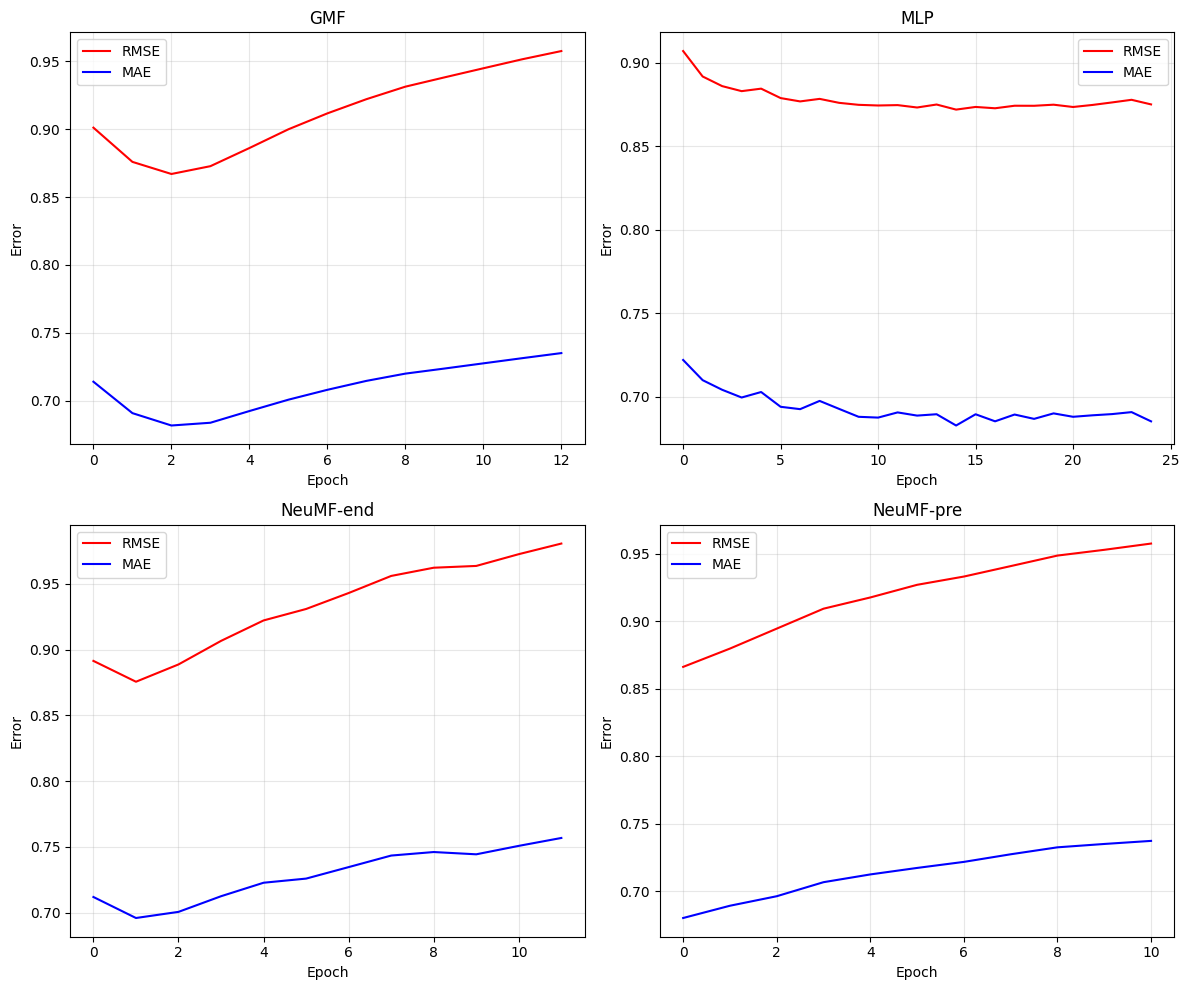

In [21]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

histories = [
    ('GMF', gmf_history),
    ('MLP', mlp_history),
    ('NeuMF-end', neumf_end_history),
    ('NeuMF-pre', neumf_pre_history)
]

for ax, (name, hist) in zip(axes.flat, histories):
    ax.plot(hist['test_rmse'], 'r-', label='RMSE')
    ax.plot(hist['test_mae'], 'b-', label='MAE')
    ax.set_title(f'{name}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, 'ncf_rating_comparison.png'), dpi=150)
plt.show()

## Summary

### Key Modifications for Rating Prediction

| Original NCF | Rating NCF |
|--------------|------------|
| BCEWithLogitsLoss | MSELoss |
| Binary labels (0/1) | Actual ratings (1-5) |
| Negative sampling | No negative sampling |
| HR@K, NDCG@K | RMSE, MAE |

### References

- He, X., et al. (2017). Neural Collaborative Filtering. WWW'17.